# Google restaurant rating prediction using Machine Learning

In [127]:
#import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

import itertools
from sklearn.pipeline import Pipeline
import scipy.sparse



## I used Google Restaurants dataset available on https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_restaurants
## Description
*This is a mutli-modal dataset of restaurants from Google Local (Google Maps). Data includes images and reviews posted by users, as well as other metadata for each restaurant.*

I thought this was an interesting dataset to explore, because everyone likes food including me.

In [129]:
#import dataset
# 1. Load the data using the standard json library
with open('filter_all_t.json', 'r') as f:
    data = json.load(f)

# 2. Convert to DataFrame using pd.Series
# This trick forces pandas to create a Series for each key, 
# effectively aligning them and filling missing spots with NaN.
df = pd.DataFrame(dict([ (k, pd.Series(v)) for k, v in data.items() ]))
print(df.head())



                                               train  \
0  {'business_id': '60567465d335d0abfb415b26', 'u...   
1  {'business_id': '6050fa9f5b4ccec8d5cae994', 'u...   
2  {'business_id': '604be10877e81aaed3cc9a1e', 'u...   
3  {'business_id': '60411e017cd8bf130362365a', 'u...   
4  {'business_id': '604139dd7cd8bf1303624208', 'u...   

                                                 val  \
0  {'business_id': '6049974fb1a0aaee3eefb0dd', 'u...   
1  {'business_id': '6040f95d7cd8bf1303622198', 'u...   
2  {'business_id': '60521c38d8c08f462b93e849', 'u...   
3  {'business_id': '605440914c439864897ed9df', 'u...   
4  {'business_id': '6050c60f5b4ccec8d5cae83e', 'u...   

                                                test  
0  {'business_id': '604bf6a75041fa50c4bce594', 'u...  
1  {'business_id': '604ee8b388c7af3f893e613b', 'u...  
2  {'business_id': '605121e75b4ccec8d5caea76', 'u...  
3  {'business_id': '6050d2cf9c93e55e75b72260', 'u...  
4  {'business_id': '6046315010ec061e056b3f81', 'u..

In [130]:
# 1. Create the TRAIN dataframe
# We use .dropna() because the 'train' list might be longer than 'val' or 'test'
train_data = df['train'].dropna().tolist()
train_df = pd.DataFrame(train_data)

# 2. Create the VALIDATION dataframe
val_data = df['val'].dropna().tolist()
val_df = pd.DataFrame(val_data)

# 3. Create the TEST dataframe
test_data = df['test'].dropna().tolist()
test_df = pd.DataFrame(test_data)


-----
# 1. EXPLORATORY ANALYSIS

## Dataset contains business_id, user_id, review_text, pics link and historical reviews.

In [131]:
# Initial checks
print("Train Set Shape:", train_df.shape)
print(train_df.head())
print("\nValidation Set Shape:", val_df.shape)
print("\nTest Set Shape:", test_df.shape)


Train Set Shape: (87013, 6)
                business_id                user_id  rating  \
0  60567465d335d0abfb415b26  101074926318992653684       4   
1  6050fa9f5b4ccec8d5cae994  117065749986299237881       5   
2  604be10877e81aaed3cc9a1e  106700937793048450809       4   
3  60411e017cd8bf130362365a  101643045857250355161       5   
4  604139dd7cd8bf1303624208  109802745326785766951       4   

                                         review_text  \
0  The tang of the tomato sauce is outstanding. A...   
1              Chicken and waffles were really good!   
2  The appetizer of colossal shrimp was very good...   
3  The fish tacos here  omg! The salad was great ...   
4  Ribs are great, as are the mac and cheese, fri...   

                                                pics  \
0  [AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0,...   
1     [AF1QipMpfxIZUT_aymQ3qPGO-QgGYzxbtLZGmHufAp2s]   
2  [AF1QipMNnqM5X9sSyZ9pXRZ1jvrURHN9bZhGdzuEXoP8,...   
3  [AF1QipM-a6AGGp4Hgk5RD0gY5sDRp5kEfB

## Dataset contains historical reviews for that user, which we can potentially use to predict future reviews by the user


In [132]:
print(train_df['history_reviews'][0])

[['101074926318992653684_6056272797d555cc6fb0d147', 'The pizza here is the real deal, perfect in every way except for the crust, which was more cracker crisp than chewy bread. Also recommend the meatball parmigiana hero, beefy, fluffy, overflowing, tangy, chunky tomato sauce, toothsome bread.'], ['101074926318992653684_604a65c2c6dc737bce7e5a3d', 'Omg the tomato sauce is everything, in the meatball appetizer, pizza & as a dip for that scratch-made focaccia. Farm-fresh salad. A variety of artisan toppings. Ask for the chili oil! Goes great with the focaccia bread.'], ['101074926318992653684_60433b8d8be5d4454df9cc51', 'First time around last year, we stuck to eggs and Benedict, which were okay not outstanding. Ours included bleskiver, a delightful Danish pancake donut, crepe, and potato pancake with German sausage. The bleskiver is fluffy yet yeasty but not too sweet.'], ['101074926318992653684_6055ebe4f69c7b117806fdaa', 'Food was lukewarm, including fried calamari.'], ['10107492631899265

In [133]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87013 entries, 0 to 87012
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      87013 non-null  object
 1   user_id          87013 non-null  object
 2   rating           87013 non-null  int64 
 3   review_text      87013 non-null  object
 4   pics             87013 non-null  object
 5   history_reviews  87013 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.0+ MB


,rating
count,87013.000000
mean,4.465252
std,0.833755
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Let's explore rating distribution

<Axes: xlabel='rating', ylabel='Proportion'>

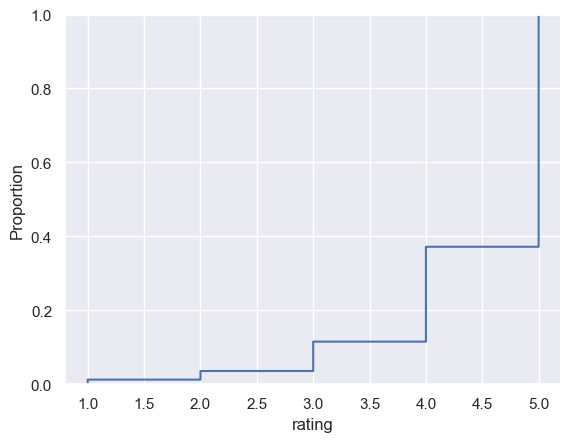

In [165]:
sns.ecdfplot(data=train_df, x='rating')

**We can see that most of the ratings are 4 stars and above. We see that ratings are integers, ie there are no fractional stars. Let's find the actual percentage of ratings below 4 stars.**

In [153]:
total_ratings = len(train_df)
ratings_below_4 = train_df[train_df['rating'] < 4].shape[0]
percentage_below_4 = (ratings_below_4 / total_ratings) * 100
print(percentage_below_4)

11.509774401526208


**Only 11.5% of all ratings in the training set are under 4 stars. This means that we have a pretty imbalanced dataset and we have to be careful not to bias for the positive ratings.**

----
# 2. IDENTIFY PREDICTIVE TASK

*1) Can we predict user sentiment for a restaurant based on their review?*<br>
*2) Do historical user reviews have an impact on the rating they would give in the future?*

# 2b. IDENTIFY RELEVANT FEATURES


| Feature | Description |
|:-----|:-----|
| review_text | user review of a restaurant, we can determine positive or negative sentiment based on review text.|
| history_reviews | all past reviews of a particular user |
| review_length | engineered feature to gauge the effort/intensity of a review |
| word_count | engineered feature to gauge complexity and breadth of the review |
| avg_rating | engineered feature of average rating per restaurant |

# 3. MODEL SELECTION
This prediction task is similar to the Good Reads dataset rating prediction. I will use similar techniques for this:
1) Naive sentiment prediction model based on average restaurant rating - this is our baseline
2) TF-IDF and Logistic Regression with different feature combinations
3) TF-IDF and Random Forest with different feature combinations

**Define positive sentiment as review of 4 stars and higher, negative sentiment below 4 stars.**<br>
Tune parameters on validation set.<br>
Test and evaluate model on the test set.

---
*Naive prediction model that is based on average rating of the restaurant.*<br>
--------------------------------------------------
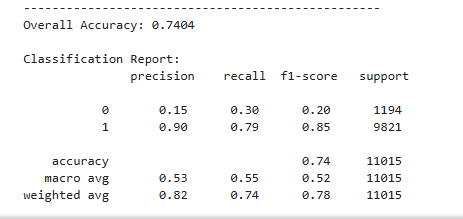



--- Naive Baseline Model (Trained on Training Data) ---
business_id
604092d865e4ba0588bb3ed5    1
604092e59d953d1f97fa088e    0
6040930e65e4ba0588bb3f22    1
6040931c9d953d1f97fa08c2    1
6040935465e4ba0588bb3f5f    1
                           ..
60572c39c4674474cff912d9    1
60572c51f69c7b1178070363    1
60572d22c4674474cff912db    1
60572d91d2ad6b7a67e27fdf    1
605730f68cd0e3d69a52284b    1
Name: rating, Length: 27896, dtype: int64
--------------------------------------------------

--- Evaluation on Test Set ---
                    business_id  rating  True_Sentiment  Predicted_Sentiment
0      604bf6a75041fa50c4bce594       5               1                    0
1      604ee8b388c7af3f893e613b       5               1                    1
2      605121e75b4ccec8d5caea76       5               1                    1
3      6050d2cf9c93e55e75b72260       5               1                    1
4      6046315010ec061e056b3f81       4               1                    1
...            

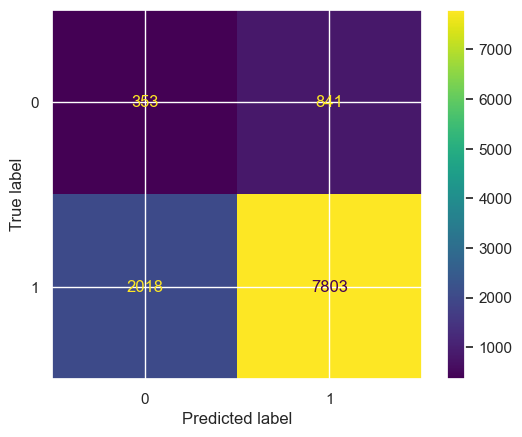

In [159]:

# Define the threshold for what constitutes a "positive" average rating
AVERAGE_RATING_THRESHOLD = 4.0
SENTIMENT_POSITIVE = 1
SENTIMENT_NEGATIVE = 0

# --- 2. Calculate the Naive Baseline (The "Model") ---

# Group by business_id and calculate the mean rating for each business
business_avg_ratings = train_df.groupby('business_id')['rating'].mean()

# Convert the average ratings into a naive sentiment prediction for the business
# If the average rating is >= 4.0, the baseline prediction for the business is Positive (1)
naive_baseline_model = (business_avg_ratings >= AVERAGE_RATING_THRESHOLD).astype(int)

print("--- Naive Baseline Model (Trained on Training Data) ---")
print(naive_baseline_model)
print("-" * 50)


# --- 3. Prediction Function ---

def predict_naive_sentiment(business_id: str, baseline_model: pd.Series) -> int:
    """
    Predicts the sentiment of a review based only on the business's
    historical average rating, ignoring the actual review text.
    
    Args:
        business_id: The ID of the restaurant.
        baseline_model: The pre-calculated Series of average rating sentiments.
        
    Returns:
        1 for Positive, 0 for Negative.
    """
    try:
        # Lookup the pre-calculated sentiment for the business
        prediction = baseline_model.loc[business_id]
        
        # Ensure the output is an integer (1 or 0)
        return int(prediction)
    except KeyError:
        # Handle cases where the business ID is new (not in training data)
        print(f"Warning: Business ID '{business_id}' not found in training data. Predicting Neutral (0).")
        # In a real system, you might predict 0 (negative) or 1 (positive) 
        # depending on your desired bias, or use a default of 3 stars (Neutral).
        return SENTIMENT_NEGATIVE 


# --- 4. Evaluation on Test Set ---

# A. Prepare the Test Data with True Labels (Ground Truth)
test_df['True_Sentiment'] = test_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# B. Get the Model Predictions for every review in the Test Set
# The prediction ignores the 'review_text' and the individual 'rating' of the test review.
test_df['Predicted_Sentiment'] = test_df['business_id'].apply(
    lambda x: predict_naive_sentiment(x, naive_baseline_model)
)

# C. Calculate Metrics
true_labels = test_df['True_Sentiment']
predictions = test_df['Predicted_Sentiment']

print("\n--- Evaluation on Test Set ---")
print(test_df[['business_id', 'rating', 'True_Sentiment', 'Predicted_Sentiment']])
print("-" * 50)

print(f"f1 score: {f1_score(true_labels, predictions):.4f}\n")
print("Classification Report:\n", classification_report(true_labels, predictions, zero_division=0))
cm_base = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base)
disp.plot()
plt.show()


---
## TF-IDF logistic regression model with features: review<br>
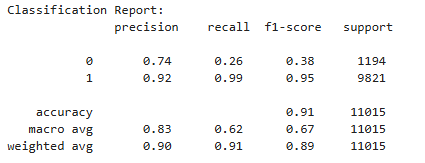

In [135]:
def prepare_data(df):
    """Creates the Sentiment label and cleans the review text."""
    # 1. Create the binary target variable
    # 1 (Positive) for 4 or 5 stars; 0 (Negative) for 1, 2, or 3 stars
    df['Sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

    # 2. Basic Text Cleaning (Handle NaNs)
    df['review_text'] = df['review_text'].fillna('')
    return df

   rating  Sentiment
0       4          1
1       5          1
2       4          1
3       5          1
4       4          1
Model training complete.

## Model Performance on Test Set ##
f1 score: 0.9513

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.26      0.38      1194
           1       0.92      0.99      0.95      9821

    accuracy                           0.91     11015
   macro avg       0.83      0.62      0.67     11015
weighted avg       0.90      0.91      0.89     11015

Confusion Matrix:

Confusion Matrix:
 [[ 305  889]
 [ 106 9715]]


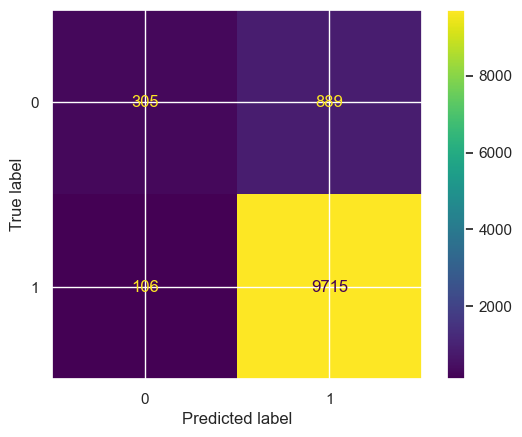

In [156]:


# Apply preparation to the datasets
train_df = prepare_data(train_df)
val_df = prepare_data(val_df) 
test_df = prepare_data(test_df)

print(train_df[['rating', 'Sentiment']].head())

# Create the Vectorizer (Fit only on the Training data!)
# max_features limits the vocabulary size, which speeds up training
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# X_train: Transform the training text into numerical features
X_train = vectorizer.fit_transform(train_df['review_text'])
y_train = train_df['Sentiment']

# X_val: Transform the validation text using the SAME vectorizer (avoid data leakage)
X_val = vectorizer.transform(val_df['review_text'])
y_val = val_df['Sentiment']

# Initialize the classifier
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

print("Model training complete.")

# --- Evaluation Steps ---

#1. Get the Test Set features (using the same fitted vectorizer)
X_test = vectorizer.transform(test_df['review_text'])
y_test = test_df['Sentiment'] 


# 2. Predict on the test data
y_pred = model.predict(X_test)

# 3. Print the results
print("\n## Model Performance on Test Set ##")
print(f"f1 score: {f1_score(y_test, y_pred):.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n")
cm_simple = confusion_matrix(y_test, y_pred, labels=model.classes_)
print("Confusion Matrix:\n", cm_simple)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_simple,
                              display_labels=model.classes_)
disp.plot()
plt.show()



---
## TF-IDF logistic regression model with features: review and user historical review.<br>
**This introduced a lot of noise and bias, users past positive reviews affected current rating too much, thus creating a lot more false-positives (1187 compared to 889 in current review only model)**<br>
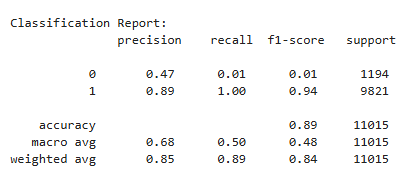

Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...
Tested 4/4 combinations. Best F1 on Val: 0.9366
Tuning Complete.

---------------------------------------------------
BEST MODEL HYPERPARAMETERS (Selected via Validation Set):
{'ngram_range': (1, 1), 'max_df': 0.75, 'min_df': 1, 'max_features': 2000, 'C': 0.1, 'penalty': 'l2'}
BEST VALIDATION SCORE (F1-score): 0.9366
---------------------------------------------------

## Final Performance on UNSEEN Test Set ##
f1-score: 0.9426

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.01      0.01      1194
           1       0.89      1.00      0.94      9821

    accuracy                           0.89     11015
   macro avg       0.68      0.50      0.48     11015
weighted avg       0.85      0.89      0.84     11015

Confusion Matrix:

Confusion Matrix:
 [[   7 1187]
 [   8 9813]]


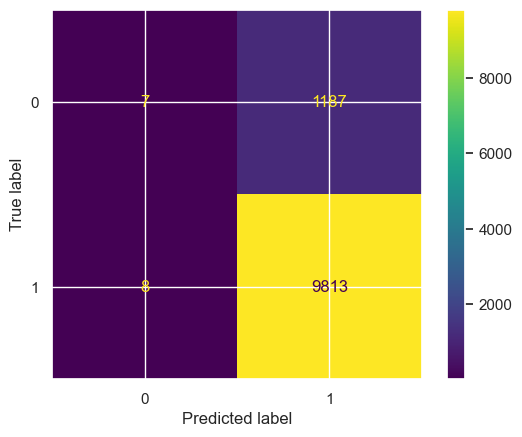

In [137]:

# --- 1. Get data 
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)


# --- 2. Data Preparation and Labeling ---

def prepare_data(df):
    """
    Creates the binary Sentiment label, cleans text, and combines
    current review text with all history review texts.
    """
    # 1 (Positive) for 4 or 5 stars; 0 (Negative) for 1, 2, or 3 stars
    df['Sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
    df['review_text'] = df['review_text'].fillna('')
    df['history_reviews'] = df['history_reviews'].fillna('')

    def extract_history_text(history_list):
        if not history_list:
            return ""
        # The history list is structured as: [[id1, text1], [id2, text2], ...]
        # We extract all the text elements (at index 1) and join them with a space.
        texts = [item[1] for item in history_list if isinstance(item, list) and len(item) > 1]
        return ' '.join(texts)

    df['history_text'] = df['history_reviews'].apply(extract_history_text)
    
    # Combine the current review text with the user's historical review text
    df['combined_text'] = df['review_text'] + ' ' + df['history_text']
    
    return df

train_df = prepare_data(train_df)
val_df = prepare_data(val_df)
test_df = prepare_data(test_df)

# Use the new 'combined_text' column as the feature set
X_train, y_train = train_df['combined_text'], train_df['Sentiment']
X_val, y_val = val_df['combined_text'], val_df['Sentiment']
X_test, y_test = test_df['combined_text'], test_df['Sentiment']


# --- 3. Define the Parameter Grid for Manual Tuning ---

param_grid = {
    'ngram_range': [(1, 1)],
    'max_df': [0.75, 0.90],
    'min_df': [1, 5],
    'max_features': [2000],
    'C': [0.1],
    'penalty': ['l2'] # Keeping this fixed for simplicity in the loop
}

# Generate all parameter combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]

# --- 4. Execute Manual Tuning (Train on Train, Evaluate on Validation) ---

best_score = 0
best_params = None

print("Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...")

for i, params in enumerate(combinations):
    # 4.1. Initialize the Pipeline with current parameters
    # Note: We don't need the tfidf_params and clf_params dictionaries anymore,
    # as we pass the parameters directly to the initialized objects.
    
    # Initialize the Vectorizer for the current loop
    vectorizer = TfidfVectorizer(stop_words='english', **{k: v for k, v in params.items() if k in ['ngram_range', 'max_df', 'min_df', 'max_features']})

    # Initialize the Classifier for the current loop
    clf = LogisticRegression(random_state=42, solver='liblinear', **{k: v for k, v in params.items() if k in ['C', 'penalty']})

    # 4.2. Fit the Vectorizer and Classifier on the Training Data
    X_train_vectorized = vectorizer.fit_transform(X_train)
    clf.fit(X_train_vectorized, y_train)

    # 4.3. Evaluate on the Validation Data
    X_val_vectorized = vectorizer.transform(X_val)
    y_val_pred = clf.predict(X_val_vectorized)
    
    # We use F1-score to compare model performance
    score = f1_score(y_val, y_val_pred, zero_division=0)

    # 4.4. Track the Best Score and Parameters
    if score > best_score:
        best_score = score
        best_params = params
    
    # Optional: Print progress
    if (i + 1) % 10 == 0 or i == len(combinations) - 1:
        print(f"Tested {i + 1}/{len(combinations)} combinations. Best F1 on Val: {best_score:.4f}")

print("Tuning Complete.")

# --- 5. Final Model Training and Evaluation on Test Set ---

print("\n---------------------------------------------------")
print("BEST MODEL HYPERPARAMETERS (Selected via Validation Set):")
print(best_params)
print(f"BEST VALIDATION SCORE (F1-score): {best_score:.4f}")
print("---------------------------------------------------")

# A. Retrain Final Model using the best parameters
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=best_params.get('ngram_range', (1, 1)),
    max_df=best_params.get('max_df', 0.90),
    min_df=best_params.get('min_df', 1),
    max_features=best_params.get('max_features', 5000)
)
final_clf = LogisticRegression(
    random_state=42, 
    solver='liblinear',
    C=best_params.get('C', 1.0),
    penalty=best_params.get('penalty', 'l2')
)

# Fit vectorizer and classifier on the Training Data
X_train_final = vectorizer.fit_transform(X_train)
final_clf.fit(X_train_final, y_train)

# B. Evaluate the final model on the unseen Test Set
X_test_final = vectorizer.transform(X_test)
y_pred_tuned = final_clf.predict(X_test_final)

print("\n## Final Performance on UNSEEN Test Set ##")
print(f"f1-score: {f1_score(y_test, y_pred_tuned):.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n")
cm_simple_historical = confusion_matrix(y_test, y_pred_tuned, labels=model.classes_)
print("Confusion Matrix:\n", cm_simple_historical)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_simple_historical,
                              display_labels=model.classes_)
disp.plot()
plt.show()

---
## TF-IDF logistic regression model with features: review AND average business rating feature.<br>
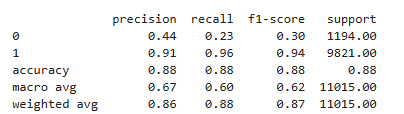

Adding average rating feature to 87013 reviews...
Adding average rating feature to 10860 reviews...
Adding average rating feature to 11015 reviews...
Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...
Tested 4/4 combinations. Best F1 on Val: 0.9314
Tuning Complete.

---------------------------------------------------
BEST MODEL HYPERPARAMETERS (Selected via Validation Set):
{'ngram_range': (1, 2), 'max_df': 0.75, 'min_df': 1, 'max_features': 5000, 'C': 10.0, 'penalty': 'l2'}
BEST VALIDATION SCORE (F1-score): 0.9314
---------------------------------------------------

## Final Performance on UNSEEN Test Set ##
f1_score: 0.9371

Classification Report:

              precision  recall  f1-score   support
0                  0.44    0.23      0.30   1194.00
1                  0.91    0.96      0.94   9821.00
accuracy           0.88    0.88      0.88      0.88
macro avg          0.67    0.60      0.62  11015.00
weighted avg       0.86    0.88      0.87  11015

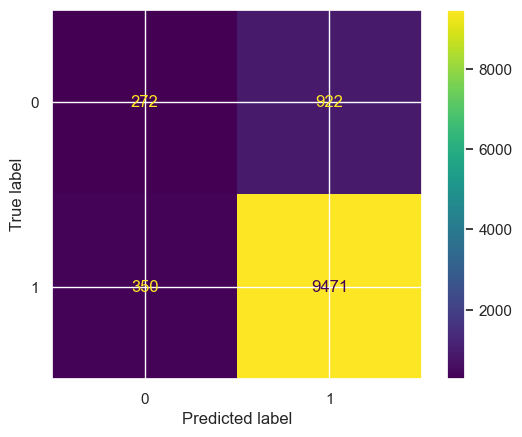

In [140]:
# --- 1. Get data 
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# --- 2. Data Preparation and Labeling ---

# Removed extract_history_text as it is no longer used

def prepare_data(df):
    """
    Creates the binary Sentiment label and uses the current review text
    for the text feature, explicitly excluding historical reviews.
    """
    # 1 (Positive) for 4 or 5 stars; 0 (Negative) for 1, 2, or 3 stars
    df['Sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
    df['review_text'] = df['review_text'].fillna('')
    
    # --- CHANGE: Set 'combined_text' to be ONLY the current 'review_text' ---
    df['combined_text'] = df['review_text']
    
    return df

def add_average_rating_feature(train_df, target_df):
    """
    Calculates the average rating for each business from the training set
    and merges this feature into the target DataFrame.
    """
    print(f"Adding average rating feature to {target_df.shape[0]} reviews...")
    # 1. Calculate the mean rating for each business from the TRAINING data
    business_avg_ratings = train_df.groupby('business_id')['rating'].mean().reset_index()
    business_avg_ratings.rename(columns={'rating': 'avg_rating'}, inplace=True)
    
    # 2. Merge this feature into the target DataFrame
    merged_df = pd.merge(
        target_df, 
        business_avg_ratings, 
        on='business_id', 
        how='left'
    )
    
    # 3. Handle new businesses (business_id not in training set)
    # Impute the overall mean rating from the training set as a neutral default.
    overall_mean_rating = train_df['rating'].mean()
    merged_df['avg_rating'] = merged_df['avg_rating'].fillna(overall_mean_rating)
    
    return merged_df


# Apply text preparation
train_df = prepare_data(train_df)
val_df = prepare_data(val_df)
test_df = prepare_data(test_df)

# Add the new numerical feature (must use train_df to calculate the averages)
train_df = add_average_rating_feature(train_df, train_df)
val_df = add_average_rating_feature(train_df, val_df)
test_df = add_average_rating_feature(train_df, test_df)

# Use the 'combined_text' (now only current review) and 'avg_rating' columns as the feature set
X_train = train_df[['combined_text', 'avg_rating']]
y_train = train_df['Sentiment']
X_val = val_df[['combined_text', 'avg_rating']]
y_val = val_df['Sentiment']
X_test = test_df[['combined_text', 'avg_rating']]
y_test = test_df['Sentiment']


# --- 3. Define the Parameter Grid for Manual Tuning ---

param_grid = {
    'ngram_range': [(1, 2)],
    'max_df': [0.75, 0.90],
    'min_df': [1, 5],
    'max_features': [5000],
    'C': [10.0],
    'penalty': ['l2'] # Keeping this fixed for simplicity in the loop
}

# Generate all parameter combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]

# --- 4. Execute Manual Tuning (Train on Train, Evaluate on Validation) ---

best_score = 0
best_params = None

print("Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...")

for i, params in enumerate(combinations):
    # 4.1. Initialize the Vectorizer and Classifier
    vectorizer = TfidfVectorizer(stop_words='english', **{k: v for k, v in params.items() if k in ['ngram_range', 'max_df', 'min_df', 'max_features']})
    clf = LogisticRegression(random_state=42, solver='liblinear', **{k: v for k, v in params.items() if k in ['C', 'penalty']})

    # 4.2. Feature Engineering and Combination on Training Data
    # Fit vectorizer only on the text data
    X_train_text_vectorized = vectorizer.fit_transform(X_train['combined_text'])
    X_train_numerical = X_train[['avg_rating']].values 
    
    # Combine TF-IDF features (sparse) with average rating feature (dense)
    X_train_vectorized = scipy.sparse.hstack([
        X_train_text_vectorized, 
        scipy.sparse.csr_matrix(X_train_numerical)
    ])
    
    clf.fit(X_train_vectorized, y_train)

    # 4.3. Evaluate on the Validation Data
    # Transform text data using the fitted vectorizer
    X_val_text_vectorized = vectorizer.transform(X_val['combined_text'])
    X_val_numerical = X_val[['avg_rating']].values
    
    X_val_vectorized = scipy.sparse.hstack([
        X_val_text_vectorized, 
        scipy.sparse.csr_matrix(X_val_numerical)
    ])
    
    y_val_pred = clf.predict(X_val_vectorized)
    
    # We use F1-score to compare model performance
    score = f1_score(y_val, y_val_pred, zero_division=0)

    # 4.4. Track the Best Score and Parameters
    if score > best_score:
        best_score = score
        best_params = params
    
    # Optional: Print progress
    if (i + 1) % 10 == 0 or i == len(combinations) - 1:
        print(f"Tested {i + 1}/{len(combinations)} combinations. Best F1 on Val: {best_score:.4f}")

print("Tuning Complete.")

# --- 5. Final Model Training and Evaluation on Test Set ---

print("\n---------------------------------------------------")
print("BEST MODEL HYPERPARAMETERS (Selected via Validation Set):")
print(best_params)
print(f"BEST VALIDATION SCORE (F1-score): {best_score:.4f}")
print("---------------------------------------------------")

# A. Retrain Final Model using the best parameters
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=best_params.get('ngram_range', (1, 1)),
    max_df=best_params.get('max_df', 0.90),
    min_df=best_params.get('min_df', 1),
    max_features=best_params.get('max_features', 5000)
)
final_clf = LogisticRegression(
    random_state=42, 
    solver='liblinear',
    C=best_params.get('C', 1.0),
    penalty=best_params.get('penalty', 'l2')
)

# Fit vectorizer and classifier on the Training Data
X_train_text_final = vectorizer.fit_transform(X_train['combined_text'])
X_train_numerical_final = X_train[['avg_rating']].values

X_train_final = scipy.sparse.hstack([
    X_train_text_final, 
    scipy.sparse.csr_matrix(X_train_numerical_final)
])
final_clf.fit(X_train_final, y_train)

# B. Evaluate the final model on the unseen Test Set
X_test_text_final = vectorizer.transform(X_test['combined_text'])
X_test_numerical_final = X_test[['avg_rating']].values

X_test_final = scipy.sparse.hstack([
    X_test_text_final, 
    scipy.sparse.csr_matrix(X_test_numerical_final)
])

y_pred_tuned = final_clf.predict(X_test_final)

print("\n## Final Performance on UNSEEN Test Set ##")
print(f"f1_score: {f1_score(y_test, y_pred_tuned):.4f}\n")
print("Classification Report:\n")

# Use a DataFrame for a clean output in the notebook
report_dict = classification_report(y_test, y_pred_tuned, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose().round(2)
print(report_df)
print("Confusion Matrix:\n")
cm_simple_avg_rating = confusion_matrix(y_test, y_pred_tuned, labels=model.classes_)
print("Confusion Matrix:\n", cm_simple_avg_rating)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_simple_avg_rating,
                              display_labels=model.classes_)
disp.plot()
plt.show()

## TF-IDF logistic regression model with features: review, avg rating, review length, word count
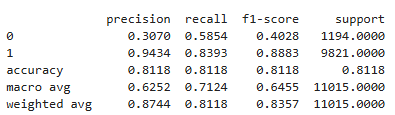

Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...
Testing 1 parameter combinations with Final Refined Manual Class Weighting.
Tested 1/1 combinations. Best F1 on Val (Neg): 0.4181
Tuning Complete.

---------------------------------------------------
BEST MODEL HYPERPARAMETERS (Selected via Validation Set):
{'ngram_range': (1, 2), 'max_df': 0.75, 'min_df': 1, 'max_features': 5000, 'C': 1.0, 'penalty': 'l1', 'neg_weight': 10.0}
BEST VALIDATION SCORE (F1-score NEG): 0.4181
---------------------------------------------------

## Final Performance on UNSEEN Test Set (Refined Manual-Weighted Hybrid Model) ##
Accuracy: 0.8118

Classification Report:

              precision  recall  f1-score     support
0                0.3070  0.5854    0.4028   1194.0000
1                0.9434  0.8393    0.8883   9821.0000
accuracy         0.8118  0.8118    0.8118      0.8118
macro avg        0.6252  0.7124    0.6455  11015.0000
weighted avg     0.8744  0.8118    0.8357  1

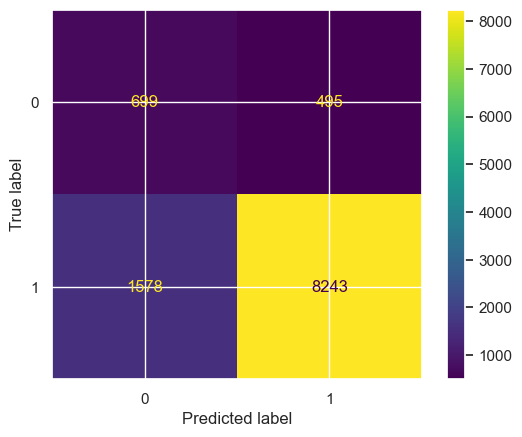

In [141]:
# --- 1. Get data 
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
# --- 2. Data Preparation and Labeling ---

def prepare_data(df):
    """
    Creates the binary Sentiment label, sets the text feature to only
    current review text, and adds a new 'review_length' feature.
    """
    # 1 (Positive) for 4 or 5 stars; 0 (Negative) for 1, 2, or 3 stars
    df['Sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
    df['review_text'] = df['review_text'].fillna('')
    
    # Text feature is ONLY the current review
    df['combined_text'] = df['review_text']

    # NEW FEATURE 1: Review Length (character count)
    df['review_length'] = df['review_text'].apply(len)
    
    # NEW FEATURE 2: Word Count (added to provide another volume signal)
    df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))
    
    return df

def add_average_rating_feature(train_df, target_df):
    """
    Calculates the average rating for each business from the training set
    and merges this feature into the target DataFrame.
    """
    # 1. Calculate the mean rating for each business from the TRAINING data
    business_avg_ratings = train_df.groupby('business_id')['rating'].mean().reset_index()
    business_avg_ratings.rename(columns={'rating': 'avg_rating'}, inplace=True)
    
    # 2. Merge this feature into the target DataFrame
    merged_df = pd.merge(
        target_df, 
        business_avg_ratings, 
        on='business_id', 
        how='left'
    )
    
    # 3. Handle new businesses (business_id not in training set)
    # Impute the overall mean rating from the training set as a neutral default.
    overall_mean_rating = train_df['rating'].mean()
    merged_df['avg_rating'] = merged_df['avg_rating'].fillna(overall_mean_rating)
    
    return merged_df


# Apply text and length preparation, now including word count
train_df = prepare_data(train_df)
val_df = prepare_data(val_df)
test_df = prepare_data(test_df)

# Add the average rating feature
train_df = add_average_rating_feature(train_df, train_df)
val_df = add_average_rating_feature(train_df, val_df)
test_df = add_average_rating_feature(train_df, test_df)

# X now contains both text ('combined_text') and numerical features ('avg_rating', 'review_length', 'word_count')
X_train = train_df[['combined_text', 'avg_rating', 'review_length', 'word_count']]
y_train = train_df['Sentiment']
X_val = val_df[['combined_text', 'avg_rating', 'review_length', 'word_count']]
y_val = val_df['Sentiment']
X_test = test_df[['combined_text', 'avg_rating', 'review_length', 'word_count']]
y_test = test_df['Sentiment']


# --- 3. Define the Parameter Grid for Manual Tuning (Final Refinement) ---

# Locking down best-performing text parameters and focusing only on an aggressive neg_weight search
param_grid = {
    # Text features fixed based on previous best results
    'ngram_range': [(1, 2)], # Bi-grams proved best
    'max_df': [0.75], 
    'min_df': [1], 
    'max_features': [5000], 
    
    # Fixed C and penalty based on best previous result
    'C': [1.0], 
    'penalty': ['l1'], 
    
    # Aggressively expanded neg_weight values to push F1-Neg higher
    'neg_weight': [10.0] 
}

# Generate all parameter combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]

# --- 4. Execute Manual Tuning (Train on Train, Evaluate on Validation) ---

best_score = 0
best_params = None

print("Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...")
print(f"Testing {len(combinations)} parameter combinations with Final Refined Manual Class Weighting.")

for i, params in enumerate(combinations):
    # 4.1. Initialize the Vectorizer and Classifier
    # Removed stop_words='english' to keep critical negative intensifiers
    vectorizer = TfidfVectorizer(stop_words=None, **{k: v for k, v in params.items() if k in ['ngram_range', 'max_df', 'min_df', 'max_features']})
    
    # Create the manual class weight dictionary
    class_weight_dict = {
        0: params['neg_weight'], # Negative Class (0) weight is tuned
        1: 1.0                   # Positive Class (1) weight is fixed at 1.0
    }
    
    # Use 'liblinear' solver which supports both L1 and L2 penalties
    clf = LogisticRegression(
        random_state=42, 
        solver='liblinear', 
        class_weight=class_weight_dict, 
        **{k: v for k, v in params.items() if k in ['C', 'penalty']}
    )
    
    # 4.2. Feature Engineering and Combination on Training Data
    X_train_text_vectorized = vectorizer.fit_transform(X_train['combined_text'])
    # Extract ALL numerical features (Avg Rating, Review Length, and NEW Word Count)
    X_train_numerical = X_train[['avg_rating', 'review_length', 'word_count']].values 
    
    # Combine TF-IDF features (sparse) with numerical features (dense)
    X_train_vectorized = scipy.sparse.hstack([
        X_train_text_vectorized, 
        scipy.sparse.csr_matrix(X_train_numerical)
    ])
    
    clf.fit(X_train_vectorized, y_train)

    # 4.3. Evaluate on the Validation Data
    X_val_text_vectorized = vectorizer.transform(X_val['combined_text'])
    # Transform: Extract ALL numerical features (Avg Rating, Review Length, and NEW Word Count)
    X_val_numerical = X_val[['avg_rating', 'review_length', 'word_count']].values
    
    X_val_vectorized = scipy.sparse.hstack([
        X_val_text_vectorized, 
        scipy.sparse.csr_matrix(X_val_numerical)
    ])
    
    y_val_pred = clf.predict(X_val_vectorized)
    
    # We use F1-score of the NEGATIVE class for tuning since it's the weak spot
    score = f1_score(y_val, y_val_pred, pos_label=0, zero_division=0) 

    # 4.4. Track the Best Score and Parameters
    if score > best_score:
        best_score = score
        best_params = params
    
    if (i + 1) % 10 == 0 or i == len(combinations) - 1:
        print(f"Tested {i + 1}/{len(combinations)} combinations. Best F1 on Val (Neg): {best_score:.4f}")

print("Tuning Complete.")

# --- 5. Final Model Training and Evaluation on Test Set ---

print("\n---------------------------------------------------")
print("BEST MODEL HYPERPARAMETERS (Selected via Validation Set):")
print(best_params)
print(f"BEST VALIDATION SCORE (F1-score NEG): {best_score:.4f}")
print("---------------------------------------------------")

# A. Retrain Final Model using the best parameters
vectorizer = TfidfVectorizer(
    stop_words=None,
    ngram_range=best_params.get('ngram_range', (1, 2)),
    max_df=best_params.get('max_df', 0.75),
    min_df=best_params.get('min_df', 1),
    max_features=best_params.get('max_features', 5000)
)
# Get the optimized class weight from the best parameters
optimized_neg_weight = best_params.get('neg_weight', 1.0)
final_class_weight = {0: optimized_neg_weight, 1: 1.0}

final_clf = LogisticRegression(
    random_state=42, 
    solver='liblinear',
    class_weight=final_class_weight, # Use the optimized manual class weight
    C=best_params.get('C', 1.0),
    penalty=best_params.get('penalty', 'l1') # Use L1 as it was the previous best
)

# Fit vectorizer and classifier on the Training Data
X_train_text_final = vectorizer.fit_transform(X_train['combined_text'])
# Extract ALL numerical features (Avg Rating, Review Length, and NEW Word Count)
X_train_numerical_final = X_train[['avg_rating', 'review_length', 'word_count']].values 

X_train_final = scipy.sparse.hstack([
    X_train_text_final, 
    scipy.sparse.csr_matrix(X_train_numerical_final)
])
final_clf.fit(X_train_final, y_train)

# B. Evaluate the final model on the unseen Test Set
X_test_text_final = vectorizer.transform(X_test['combined_text'])
# Transform: Extract ALL numerical features (Avg Rating, Review Length, and NEW Word Count)
X_test_numerical_final = X_test[['avg_rating', 'review_length', 'word_count']].values 

X_test_final = scipy.sparse.hstack([
    X_test_text_final, 
    scipy.sparse.csr_matrix(X_test_numerical_final)
])

y_pred_tuned = final_clf.predict(X_test_final)

print("\n## Final Performance on UNSEEN Test Set (Refined Manual-Weighted Hybrid Model) ##")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}\n")
print("Classification Report:\n")

# Use a DataFrame for a clean output in the notebook
report_dict = classification_report(y_test, y_pred_tuned, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose().round(4)
print(report_df)
print("Confusion Matrix:\n")
cm_improved_hybrid = confusion_matrix(y_test, y_pred_tuned, labels=model.classes_)
print("Confusion Matrix:\n", cm_improved_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_improved_hybrid,
                              display_labels=model.classes_)
disp.plot()
plt.show()

## TF-IDF with Random Forest
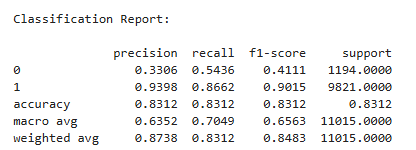

Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...
Testing 1 parameter combinations with Random Forest Classifier.
Tested 1/1 combinations. Best F1 on Val (Neg): 0.4287
Tuning Complete.

---------------------------------------------------
BEST MODEL HYPERPARAMETERS (Selected via Validation Set):
{'ngram_range': (1, 2), 'max_df': 0.75, 'min_df': 1, 'max_features': 5000, 'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5}
BEST VALIDATION SCORE (F1-score NEG): 0.4287
---------------------------------------------------

## Final Performance on UNSEEN Test Set (Random Forest Hybrid Model) ##
Accuracy: 0.8312

Classification Report:

              precision  recall  f1-score     support
0                0.3306  0.5436    0.4111   1194.0000
1                0.9398  0.8662    0.9015   9821.0000
accuracy         0.8312  0.8312    0.8312      0.8312
macro avg        0.6352  0.7049    0.6563  11015.0000
weighted avg     0.8738  0.8312    0.8483  11015.000

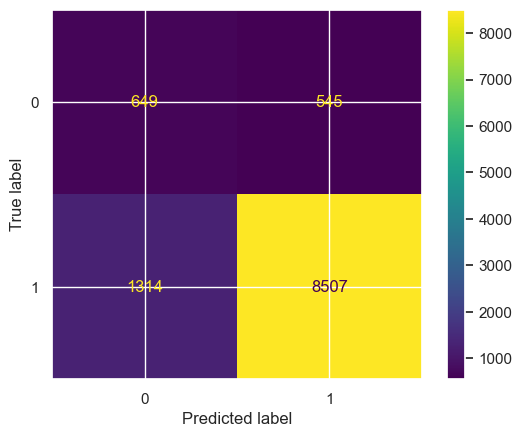

In [142]:
from sklearn.ensemble import RandomForestClassifier # Switched model

# --- 1. Get data 
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# --- 2. Data Preparation and Labeling ---

def prepare_data(df):
    """
    Creates the binary Sentiment label, sets the text feature to only
    current review text, and adds new numerical features.
    """
    # 1 (Positive) for 4 or 5 stars; 0 (Negative) for 1, 2, or 3 stars
    df['Sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
    df['review_text'] = df['review_text'].fillna('')
    
    # Text feature is ONLY the current review
    df['combined_text'] = df['review_text']

    # NEW FEATURE 1: Review Length (character count)
    df['review_length'] = df['review_text'].apply(len)
    
    # NEW FEATURE 2: Word Count (added to provide another volume signal)
    df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))
    
    return df

def add_average_rating_feature(train_df, target_df):
    """
    Calculates the average rating for each business from the training set
    and merges this feature into the target DataFrame.
    """
    # 1. Calculate the mean rating for each business from the TRAINING data
    business_avg_ratings = train_df.groupby('business_id')['rating'].mean().reset_index()
    business_avg_ratings.rename(columns={'rating': 'avg_rating'}, inplace=True)
    
    # 2. Merge this feature into the target DataFrame
    merged_df = pd.merge(
        target_df, 
        business_avg_ratings, 
        on='business_id', 
        how='left'
    )
    
    # 3. Handle new businesses (business_id not in training set)
    # Impute the overall mean rating from the training set as a neutral default.
    overall_mean_rating = train_df['rating'].mean()
    merged_df['avg_rating'] = merged_df['avg_rating'].fillna(overall_mean_rating)
    
    return merged_df


# Apply text and length preparation, now including word count
train_df = prepare_data(train_df)
val_df = prepare_data(val_df)
test_df = prepare_data(test_df)

# Add the average rating feature
train_df = add_average_rating_feature(train_df, train_df)
val_df = add_average_rating_feature(train_df, val_df)
test_df = add_average_rating_feature(train_df, test_df)

# X now contains both text ('combined_text') and numerical features ('avg_rating', 'review_length', 'word_count')
X_train = train_df[['combined_text', 'avg_rating', 'review_length', 'word_count']]
y_train = train_df['Sentiment']
X_val = val_df[['combined_text', 'avg_rating', 'review_length', 'word_count']]
y_val = val_df['Sentiment']
X_test = test_df[['combined_text', 'avg_rating', 'review_length', 'word_count']]
y_test = test_df['Sentiment']


# --- 3. Define the Parameter Grid for Manual Tuning (Random Forest) ---

# Locking down best-performing text parameters, tuning RF specific parameters
param_grid = {
    # Text features fixed based on previous best results
    'ngram_range': [(1, 2)], 
    'max_df': [0.75], 
    'min_df': [1], 
    'max_features': [5000], 
    
    # Random Forest specific hyperparameters for tuning
    'n_estimators': [50],  # Number of trees in the forest
    'max_depth': [20],     # Maximum depth of the tree (None means full depth)
    'min_samples_split': [5]      # Minimum number of samples required to split an internal node
}

# Generate all parameter combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]

# --- 4. Execute Manual Tuning (Train on Train, Evaluate on Validation) ---

best_score = 0
best_params = None

print("Starting Manual Hyperparameter Tuning (Training on Train, Scoring on Validation)...")
print(f"Testing {len(combinations)} parameter combinations with Random Forest Classifier.")

for i, params in enumerate(combinations):
    # 4.1. Initialize the Vectorizer and Classifier
    vectorizer = TfidfVectorizer(stop_words=None, **{k: v for k, v in params.items() if k in ['ngram_range', 'max_df', 'min_df', 'max_features']})
    
    # Random Forest Classifier with class_weight='balanced'
    clf = RandomForestClassifier(
        random_state=42, 
        class_weight='balanced', # Automatically handles class imbalance
        **{k: v for k, v in params.items() if k in ['n_estimators', 'max_depth', 'min_samples_split']}
    )
    
    # 4.2. Feature Engineering and Combination on Training Data
    X_train_text_vectorized = vectorizer.fit_transform(X_train['combined_text'])
    # Extract ALL numerical features (Avg Rating, Review Length, and Word Count)
    X_train_numerical = X_train[['avg_rating', 'review_length', 'word_count']].values 
    
    # Combine TF-IDF features (sparse) with numerical features (dense)
    # NOTE: Random Forest handles sparse matrices less efficiently than dense, 
    # but we proceed to keep the hybrid feature set.
    X_train_vectorized = scipy.sparse.hstack([
        X_train_text_vectorized, 
        scipy.sparse.csr_matrix(X_train_numerical)
    ]).toarray() # Convert to dense array for compatibility with RF

    clf.fit(X_train_vectorized, y_train)

    # 4.3. Evaluate on the Validation Data
    X_val_text_vectorized = vectorizer.transform(X_val['combined_text'])
    # Transform: Extract ALL numerical features (Avg Rating, Review Length, and Word Count)
    X_val_numerical = X_val[['avg_rating', 'review_length', 'word_count']].values
    
    X_val_vectorized = scipy.sparse.hstack([
        X_val_text_vectorized, 
        scipy.sparse.csr_matrix(X_val_numerical)
    ]).toarray() # Convert to dense array for compatibility with RF
    
    y_val_pred = clf.predict(X_val_vectorized)
    
    # We use F1-score of the NEGATIVE class for tuning
    score = f1_score(y_val, y_val_pred, pos_label=0, zero_division=0) 

    # 4.4. Track the Best Score and Parameters
    if score > best_score:
        best_score = score
        best_params = params
    
    if (i + 1) % 10 == 0 or i == len(combinations) - 1:
        print(f"Tested {i + 1}/{len(combinations)} combinations. Best F1 on Val (Neg): {best_score:.4f}")

print("Tuning Complete.")

# --- 5. Final Model Training and Evaluation on Test Set ---

print("\n---------------------------------------------------")
print("BEST MODEL HYPERPARAMETERS (Selected via Validation Set):")
print(best_params)
print(f"BEST VALIDATION SCORE (F1-score NEG): {best_score:.4f}")
print("---------------------------------------------------")

# A. Retrain Final Model using the best parameters
vectorizer = TfidfVectorizer(
    stop_words=None,
    ngram_range=best_params.get('ngram_range', (1, 2)),
    max_df=best_params.get('max_df', 0.75),
    min_df=best_params.get('min_df', 1),
    max_features=best_params.get('max_features', 5000)
)

final_clf = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    n_estimators=best_params.get('n_estimators', 100),
    max_depth=best_params.get('max_depth', None),
    min_samples_split=best_params.get('min_samples_split', 2)
)

# Fit vectorizer and classifier on the Training Data
X_train_text_final = vectorizer.fit_transform(X_train['combined_text'])
# Extract ALL numerical features (Avg Rating, Review Length, and Word Count)
X_train_numerical_final = X_train[['avg_rating', 'review_length', 'word_count']].values 

X_train_final = scipy.sparse.hstack([
    X_train_text_final, 
    scipy.sparse.csr_matrix(X_train_numerical_final)
]).toarray() # Convert to dense array
final_clf.fit(X_train_final, y_train)

# B. Evaluate the final model on the unseen Test Set
X_test_text_final = vectorizer.transform(X_test['combined_text'])
# Transform: Extract ALL numerical features (Avg Rating, Review Length, and Word Count)
X_test_numerical_final = X_test[['avg_rating', 'review_length', 'word_count']].values 

X_test_final = scipy.sparse.hstack([
    X_test_text_final, 
    scipy.sparse.csr_matrix(X_test_numerical_final)
]).toarray() # Convert to dense array

y_pred_tuned = final_clf.predict(X_test_final)

print("\n## Final Performance on UNSEEN Test Set (Random Forest Hybrid Model) ##")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}\n")
print("Classification Report:\n")

# Use a DataFrame for a clean output in the notebook
report_dict = classification_report(y_test, y_pred_tuned, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose().round(4)
print(report_df)
print("Confusion Matrix:\n")
cm_random_forest = confusion_matrix(y_test, y_pred_tuned, labels=model.classes_)
print("Confusion Matrix:\n", cm_random_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest,
                              display_labels=model.classes_)
disp.plot()
plt.show()

# 4. RELATED LITERATURE
Personalized Showcases: Generating Multi-Modal Explanations for Recommendations
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley
arXiv:2207.00422, 2022 https://arxiv.org/pdf/2207.00422.pdf <br>
Yelp Review Rating Prediction: Machine Learning and Deep Learning Models Zefang Liu
arXiv:2012.06690 [cs.CL] https://doi.org/10.48550/arXiv.2012.06690



# 5. RESULTS AND CONCLUSIONS

In [160]:
# Define the model names
model_names = [
    'Naive Baseline (Avg Rating Only)', 
    'TF-IDF (Base Text Only)', 
    'TF-IDF + Historical Reviews', 
    'TF-IDF + Avg Restaurant Rating (Hybrid)',
    'TF-IDF + Imporved Negative class',
    'TF-IDF + Random Forest'
]
confusion_matrices = [cm_base, cm_simple, cm_simple_historical, cm_simple_avg_rating, cm_improved_hybrid, cm_random_forest]

# --- 2. Helper Function to Extract Metrics ---

def calculate_f1(precision, recall):
    """Calculates the F1-Score from precision and recall."""
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)


def extract_metrics(cm):
    """
    Extracts TN, FP, FN, TP, calculates Accuracy, Precision, Recall, and F1-Score
    for both Positive and Negative classes from a confusion matrix.
    """
    # TN, FP, FN, TP are the four quadrants of the matrix
    TN, FP = cm[0, 0], cm[0, 1]
    FN, TP = cm[1, 0], cm[1, 1]
    
    # Calculate derived metrics
    Total = TN + FP + FN + TP
    Accuracy = (TN + TP) / Total
    
    # --- POSITIVE CLASS (1) METRICS ---
    # Precision (Pos)
    Precision_Pos = TP / (TP + FP) if (TP + FP) > 0 else 0
    # Recall (Pos)
    Recall_Pos = TP / (TP + FN) if (TP + FN) > 0 else 0
    # F1-Score (Pos)
    F1_Pos = calculate_f1(Precision_Pos, Recall_Pos)

    # --- NEGATIVE CLASS (0) METRICS ---
    # Precision (Neg)
    Precision_Neg = TN / (TN + FN) if (TN + FN) > 0 else 0
    # Recall (Neg)
    Recall_Neg = TN / (TN + FP) if (TN + FP) > 0 else 0
    # F1-Score (Neg)
    F1_Neg = calculate_f1(Precision_Neg, Recall_Neg)
    
    return {
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP,
        'Accuracy': Accuracy,
        'Precision (Pos)': Precision_Pos,
        'Recall (Pos)': Recall_Pos,
        'F1-Score (Pos)': F1_Pos,        # NEW
        'F1-Score (Neg)': F1_Neg         # NEW
    }

# --- 3. Create the Comparison DataFrame ---

results = []
for cm in confusion_matrices:
    results.append(extract_metrics(cm))

comparison_df = pd.DataFrame(results, index=model_names)

# Sort columns for better readability
column_order = [
    'TN', 'FP', 'FN', 'TP', 
    'Accuracy', 
    'F1-Score (Pos)', 'F1-Score (Neg)' # Updated column order
]
comparison_df = comparison_df[column_order]

# Format numerical columns for clean display
comparison_df['Accuracy'] = comparison_df['Accuracy'].astype(float).apply(lambda x: f"{x:.4f}")
comparison_df['F1-Score (Pos)'] = comparison_df['F1-Score (Pos)'].astype(float).apply(lambda x: f"{x:.4f}") # Formatting F1-Pos
comparison_df['F1-Score (Neg)'] = comparison_df['F1-Score (Neg)'].astype(float).apply(lambda x: f"{x:.4f}") # Formatting F1-Neg
comparison_df[['TN', 'FP', 'FN', 'TP']] = comparison_df[['TN', 'FP', 'FN', 'TP']].astype(int)

# --- 4. Output the Comparison Table ---

print("## Model Performance Comparison (Confusion Matrix and Key Metrics) ##")
print(comparison_df.to_markdown(numalign="left", stralign="left"))

## Model Performance Comparison (Confusion Matrix and Key Metrics) ##
|                                         | TN   | FP   | FN   | TP   | Accuracy   | F1-Score (Pos)   | F1-Score (Neg)   |
|:----------------------------------------|:-----|:-----|:-----|:-----|:-----------|:-----------------|:-----------------|
| Naive Baseline (Avg Rating Only)        | 353  | 841  | 2018 | 7803 | 0.7404     | 0.8452           | 0.198            |
| TF-IDF (Base Text Only)                 | 305  | 889  | 106  | 9715 | 0.9097     | 0.9513           | 0.3801           |
| TF-IDF + Historical Reviews             | 7    | 1187 | 8    | 9813 | 0.8915     | 0.9426           | 0.0116           |
| TF-IDF + Avg Restaurant Rating (Hybrid) | 272  | 922  | 350  | 9471 | 0.8845     | 0.9371           | 0.2996           |
| TF-IDF + Imporved Negative class        | 912  | 282  | 2177 | 7644 | 0.7768     | 0.8614           | 0.4259           |
| TF-IDF + Random Forest                  | 649  | 545  | 1314 | 8507

## Model Performance Comparison (Confusion Matrix and Key Metrics) ##
|                                         | TN   | FP   | FN   | TP   | Accuracy   | F1-Score (Pos)   | F1-Score (Neg)   |
|:----------------------------------------|:-----|:-----|:-----|:-----|:-----------|:-----------------|:-----------------|
| Naive Baseline (Avg Rating Only)        | 353  | 841  | 2018 | 7803 | 0.7404     | 0.8452           | 0.198            |
| TF-IDF (Base Text Only)                 | 305  | 889  | 106  | 9715 | 0.9097     | 0.9513           | 0.3801           |
| TF-IDF + Historical Reviews             | 7    | 1187 | 8    | 9813 | 0.8915     | 0.9426           | 0.0116           |
| TF-IDF + Avg Restaurant Rating (Hybrid) | 272  | 922  | 350  | 9471 | 0.8845     | 0.9371           | 0.2996           |
| TF-IDF + Improved Negative class        | 699  | 495  | 1578 | 8243 | 0.8118     | 0.8883           | 0.4028           |
| TF-IDF + Random Forest                  | 649  | 545  | 1314 | 8507 | 0.8312     | 0.9015           | 0.4111           |

As discussed before, the dataset contains unbalanced rating distribution. Negative ratings (under 4 stars) comprise only 11.5% of the training set. This means if we're not careful, we can have very good accuracy with predicting only the positive class. To account for this I included F1-Score metrics for both the positive and negative class to visualize model performance in both GOOD and BAD rating predictions. F1-Score formula:<br>

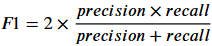 <br>

We set a pretty good baseline by predicting future customer sentiment for a particular restaurant by simply using the average rating of that restaurant. If the average rating was below 4 stars, we would predict the customer would leave a negative review in the future. And vice-versa. Surprisingly this was a pretty good guess with 74% accuracy! Intuaitively it makes sense, if a place has great food and service, then it would most likely stay that way. <br>

Using a simple Term Frequency-Inverse Document Frequency (TF-IDF) and Logistic regression provided impressive results of over 90% accuracy. However if we look closely 889 out of 1194 negative reviews were incorrectly classified as positive (False Positive). F1-Score(Neg) has improved compared to the baseline, however we try to improve it further.<br>

Surprisingly including historical reviews as a feature made the model always predict positive. Which if we think more about - it makes sense. Just because a customer left a positive review in the past, doesn't mean that they will never leave a negative one in the future. I decided to exclude this feature in the next iterations.<br>

Including avg. rating in the feature degraded the performance slightly, but I decided to leave it in the features since I felt like it's a decent predictor of customer sentiment. <br>

Next we included review length and unique word count to help the model further understand the sentiment in the review, at the same time we change logistic regression to 'balanced' which helps the model to weigh the negative class more. This resulted in a lot more False Negatives, however in relative terms, prediction of negative class improved 2x compared to baseline (from 353 to 699 True Negatives). <br>

To get positive predictions back to around 90% mark we tried Random Forest model which improved both F1-Scores. This is the final model that we felt could not get any better with the methods that we used. <br>

For further improvements - potentially Neural Networks and LLMs can be used.



## Conclusion
In summary due to class imbalance in the data, it was a challange to predict negative class effectively using standard ML methods. Best performing model for predicting negative reviews was Random Forest with 0.41 F1-Score and 83% overall accuracy. I learned that it is crucial to keep in mind data imbalances and biases even if evaluation numbers look really good on paper. Another key takeaway is that historical behavior of a customer doesn't always transalate to good predictions (in this case) as shown by model performance degradation after including historical reviews in the feature set.<br>
Author: Kostya Kravchenko - UCSD - Master of Data Science program